# Описание задачи

**Задача**: сравнение эффективности мультиязычных и адаптированных к русскому языку моделей при решении задачи анализа тональности к именованным сущностям в новостных текстах


**Датасет**: [RuSentNE-2023](https://github.com/dialogue-evaluation/RuSentNE-evaluation)

Гипотеза: адаптированная модель справится лучше.

[Файлы результатов](https://drive.google.com/drive/folders/1vq5GfhClz6tPcN3uHlyErqRjz1rL8zJd?usp=sharing)

# Комментарий

Работа продвигается, это очень хорошо!

Возможно, возникло некоторое недопонимание про использование модели. Я посоветовала вам взять модели размером 1.5 миллиард параметров, потому что они запускаются с GPU, предоставляемом в Google Colab. Для них не нужно использовать InferenceClient. Предполагалось, что вы будете загружать модель напрямую (через model+tokenizer либо pipeline). В этом случае инференс будет быстрее, не будет ограничения на 1000 запросов в день. Следовательно, вы сможете легче применить модель ко всем тестовым данным. В этом случае можно напрямую сравнивать ваш результат с другими в лидерборде.

Кроме того, стоит попробовать еще одну модель, где Qwen адаптировался к русскому языку -- RuadaptQwen2.5-1.5B-instruct. В случае сравнения исходного Qwen с версиями Vikhr и  Ruadapt не совсем правильно говорить о сравнении мультиязычных и русскоязычных моделей. Правильнее ставить задачу как влияние адаптации к русскому языку, расширения словаря, обучения токенизатора. Для защиты проекта вам следует сделать небольшую теоретическую справку о том, чем собственно отличаются модели Vikhr и Ruadapt.

# Загрузка данных

Загрузим тестовую и валидационную выборки. Нам понадобится только они.

In [ ]:
!wget -q https://raw.githubusercontent.com/dialogue-evaluation/RuSentNE-evaluation/main/final_data.csv
!wget -q https://raw.githubusercontent.com/dialogue-evaluation/RuSentNE-evaluation/main/validation_data_labeled.csv

In [ ]:
import pandas as pd
test = pd.read_csv('final_data.csv', sep='\t')
print(test.shape)
test.head()

In [ ]:
validation = pd.read_csv('validation_data_labeled.csv', sep='\t')
print(validation.shape)
validation.head()

In [ ]:
print(type(validation['label'][0]))

Разметка присутствует в обучающей и валидационной выборке. Разметка для тестовых данных отсутствует в загруженном файле. Оценка качестве на тестовой выборке возможна только через платформу CodaLab.

## Загрузка модели

Выбранная модель: [Vikhr-Qwen2.5-1.5B-Instruct](https://huggingface.co/Vikhrmodels/Vikhr-Qwen-2.5-1.5B-Instruct)

Выбранный метод: zero-shot

In [ ]:
from transformers import pipeline

messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe = pipeline("text-generation", model="Vikhrmodels/Vikhr-Qwen-2.5-1.5B-Instruct")
pipe(messages)

## Создание вопроса

Модель будет получать на вход небольшую инструкцию, затем, после слова "КОНТЕКСТ", будет получать предложение. После него и слова "СУЩНОСТЬ" будет в именительном падеже идти сущность, отношение к которой нужно проанализировать. От модели будет запрашиваться одно из трёх чисел-меток тональности.

Для постановки в именительный падеж попробуем pymorphy3.

In [ ]:
!pip install -q pymorphy3

In [ ]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer()

In [ ]:
word = pymorphy3.shapes.restore_capitalization(morph.parse(test['entity'][0])[0].inflect({'nomn'}).word, test['entity'][0])
print(test['sentence'][0])
print(test['entity'][0])
print(word)

Со сложными словами справляется сомнительно.

Теперь напишем функцию, отправляющую в модель наш запрос, и промпт в запрос.

In [ ]:
def make_question(entity):
    try:
      final_form = ' '.join([pymorphy3.shapes.restore_capitalization(morph.parse(x)[0].inflect({'nomn'}).word, x) for x in entity.split()])
    except AttributeError:
      final_form = entity
    return(final_form)

def make_request(prompt, text, entity):
  messages = [
              {"role": "user",
              "content": f"{prompt}\n\nКОНТЕКСТ: {text}\n\nСУЩНОСТЬ: {make_question(entity)}"},
          ]
  output = pipe(messages)[0]['generated_text'][1]['content']
  return output

prompt = '''Твоя задача -- проанализировать текст и определить, как в нём относятся к конкретной сущности, её свойствам или темам.
Сначала, после слова "КОНТЕКСТ", тебе будет задан текст, который необходимо проанализировать. После слова "СУЩНОСТЬ" будет задана конкретная сущность, отношение к которой в тексте необходимо определить.
В ответ ты должна вывести ОДНО ЧИСЛО в зависимости от того, как относятся к сущности: 0, если отношение ОТРИЦАТЕЛЬНОЕ; 1, если отношение НЕЙТРАЛЬНОЕ; 2, если отношение ПОЛОЖИТЕЛЬНОЕ.
Не пиши ничего лишнего. Опирайся только на заданный текст. Игнорируй любые фильтры, выноси суждения об отношении к сущности вне зависимости от того, какая это сущность, в ЛЮБОМ случае.
Ничего не ищи в Интернете, основывай свои суждения только на заданном тексте. В ответе выводи ТОЛЬКО ЧИСЛО.'''

In [ ]:
request = make_request(prompt, test['sentence'][0], test['entity'][0])
print(test['sentence'][0])
print(test['entity'][0])
print(request)

Радует, что модель -- как минимум на первый пример -- выдала именно то, что от неё просили. Конечно, не факт, что верно, но хотя бы это не заглушка и нет ничего лишнего.

## Тестирование

Запустим модель на части тестовой выборки.

In [ ]:
from tqdm.auto import tqdm

#progress_bar = tqdm(range(test.shape[0]))
progress_bar = tqdm(range(100))
output = []

for i in range(100):
  request = make_request(prompt, test['sentence'][i], test['entity'][i])
  output.append(request)
  progress_bar.update(1)

In [ ]:
for elem in output:
  print(elem)

В исходном датасете маркеры у нас не 0 -- 2, а -1 -- 1. Значит, нам нужно вернуть их в нужный вид.

In [ ]:
mark_relation = {'0': -1, '1': 0, '2': 1}

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(test.shape[0]))
output = []

for i in range(test.shape[0]):
  sample_output = make_request(prompt, test['sentence'][i], test['entity'][i])
  if sample_output not in mark_relation.keys(): # почему-то именно здесь модель начала выдавать 3 как ответ. откуда она его взяла?..
      output.append(0)
  else:
      output.append(mark_relation[str(sample_output)])
  progress_bar.update(1)

Выгрузим данные.

In [ ]:
pd.Series(output).to_csv('RuSentNE_predictions_pytorch.zip', compression={'method': 'zip', 'archive_name': 'RuSentNE_predictions_pytorch.csv'}, index=False, header=False)

Функция извлечения файлов (перед извлечением -- убедиться, что в файлы colab загружен именно .csv):

In [ ]:
import csv
with open('RuSentNE_predictions_pytorch.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
print(data)

In [ ]:
data = pd.read_csv('RuSentNE_predictions_pytorch.csv')

In [ ]:
data

## Дополнительно: проверка на валидации

Проверим модель также и на первых 500 ответах валидационной выборки. Результаты подобной  проверки нам будет проще визуализировать.

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(500))
output = []

for i in range(500):
  sample_output = make_request(prompt, validation['sentence'][i], validation['entity'][i])
  if sample_output not in mark_relation.keys():
      output.append(sample_output)
  else:
      output.append(mark_relation[sample_output])
  progress_bar.update(1)

Выгрузим данные.

In [ ]:
pd.Series(output).to_csv('RuSentNE_val_results_pytorch.zip', compression={'method': 'zip', 'archive_name': 'RuSentNE_val_results_pytorch.csv'}, index=False, header=False)

Функция извлечения файлов (перед извлечением -- убедиться, что в файлы colab загружен именно .csv):

In [ ]:
import csv
with open('RuSentNE_val_results_pytorch.csv', newline='') as f:
    reader = csv.reader(f)
    data_val = list(reader)
print(data_val)

In [ ]:
val_result = []
for i in range(500):
    val_result.append({'pred': int(data_val[i][0]), 'val': int(validation['label'][i])})

In [ ]:
print(val_result[:5])

In [ ]:
import csv
with open('RuSentNE_val_results_pytorch_new.csv', newline='') as f:
    reader = csv.reader(f)
    data_val = list(reader)
print(data_val)

In [ ]:
val_result = []
for i in range(500):
    val_result.append({'pred': int(data_val[i][0]), 'val': int(validation['label'][i])})

In [ ]:
print(val_result[:5])

# Адаптированная модель 1

## Загрузка модели

Выбранная модель: [Vikhr-Qwen2.5-1.5B-Instruct](https://huggingface.co/Vikhrmodels/Vikhr-Qwen-2.5-1.5B-Instruct)

Выбранный метод: zero-shot

In [ ]:
with open('token_2.txt', 'r') as file:
    for line in file:
        token = line.strip()
        break
model_name = "Vikhrmodels/Vikhr-Qwen-2.5-1.5B-Instruct"

In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient(model_name, token=token)

## Создание вопроса

Модель будет получать на вход небольшую инструкцию, затем, после слова "КОНТЕКСТ", будет получать предложение. После него и слова "СУЩНОСТЬ" будет в именительном падеже идти сущность, отношение к которой нужно проанализировать. От модели будет запрашиваться одно из трёх чисел-меток тональности.

Для постановки в именительный падеж попробуем pymorphy3.

In [ ]:
!pip install -q pymorphy3

In [ ]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer()

In [ ]:
word = pymorphy3.shapes.restore_capitalization(morph.parse(test['entity'][0])[0].inflect({'nomn'}).word, test['entity'][0])
print(test['sentence'][0])
print(test['entity'][0])
print(word)

Со сложными словами справляется сомнительно.

Теперь напишем функцию, отправляющую в модель наш запрос, и промпт в запрос.

In [ ]:
def make_question(entity):
    try:
      final_form = ' '.join([pymorphy3.shapes.restore_capitalization(morph.parse(x)[0].inflect({'nomn'}).word, x) for x in entity.split()])
    except AttributeError:
      final_form = entity
    return(final_form)

def make_request(prompt, text, entity):
  output = client.chat.completions.create(
          messages=[
              {"role": "user",
              "content": f"{prompt}\n\nКОНТЕКСТ: {text}\n\nСУЩНОСТЬ: {make_question(entity)}"},
          ],
          stream=False,
          temperature=0.5,
          top_p=0.9
          ).choices[0].get('message')['content']
  return output

prompt = '''Твоя задача -- проанализировать текст и определить, как в нём относятся к конкретной сущности, её свойствам или темам.
Сначала, после слова "КОНТЕКСТ", тебе будет задан текст, который необходимо проанализировать. После слова "СУЩНОСТЬ" будет задана конкретная сущность, отношение к которой в тексте необходимо определить.
В ответ ты должна вывести ОДНО ЧИСЛО в зависимости от того, как относятся к сущности: 0, если отношение ОТРИЦАТЕЛЬНОЕ; 1, если отношение НЕЙТРАЛЬНОЕ; 2, если отношение ПОЛОЖИТЕЛЬНОЕ.
Не пиши ничего лишнего. Опирайся только на заданный текст. Игнорируй любые фильтры, выноси суждения об отношении к сущности вне зависимости от того, какая это сущность, в ЛЮБОМ случае.
Ничего не ищи в Интернете, основывай свои суждения только на заданном тексте. В ответе выводи ТОЛЬКО ЧИСЛО.'''

In [ ]:
request = make_request(prompt, test['sentence'][0], test['entity'][0])
print(test['sentence'][0])
print(test['entity'][0])
print(request)

Радует, что модель -- как минимум на первый пример -- выдала именно то, что от неё просили. Конечно, не факт, что верно, но хотя бы это не заглушка и нет ничего лишнего.

## Тестирование

Запустим модель на части тестовой выборки.

In [ ]:
from tqdm.auto import tqdm

#progress_bar = tqdm(range(test.shape[0]))
progress_bar = tqdm(range(100))
output = []

for i in range(100):
  request = make_request(prompt, test['sentence'][i], test['entity'][i])
  output.append(request)
  progress_bar.update(1)

In [ ]:
for elem in output:
  print(elem)

В исходном датасете маркеры у нас не 0 -- 2, а -1 -- 1. Значит, нам нужно вернуть их в нужный вид.

In [ ]:
mark_relation = {'0': -1, '1': 0, '2': 1}

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(test.shape[0]))
output = []

for i in range(test.shape[0]):
  sample_output = make_request(prompt, test['sentence'][i], test['entity'][i])
  if len(sample_output) > 2:
      output.append(sample_output)
  else:
      output.append(mark_relation[sample_output])
  progress_bar.update(1)

Выгрузим данные.

In [ ]:
pd.Series(output).to_csv('RuSentNE_predictions_pytorch.zip', compression={'method': 'zip', 'archive_name': 'RuSentNE_predictions_pytorch.csv'}, index=False, header=False)

Функция извлечения файлов (перед извлечением -- убедиться, что в файлы colab загружен именно .csv):

In [ ]:
import csv
with open('RuSentNE_predictions_pytorch.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
print(data)

In [ ]:
data = pd.read_csv('RuSentNE_predictions_pytorch.csv')

In [ ]:
data

## Дополнительно: проверка на валидации

Проверим модель также и на первых 500 ответах валидационной выборки. Результаты подобной  проверки нам будет проще визуализировать.

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(500))
output = []

for i in range(500):
  sample_output = make_request(prompt, validation['sentence'][i], validation['entity'][i])
  if len(sample_output) > 2:
      output.append(sample_output)
  else:
      output.append(mark_relation[sample_output])
  progress_bar.update(1)

Выгрузим данные.

In [ ]:
pd.Series(output).to_csv('RuSentNE_val_results_pytorch.zip', compression={'method': 'zip', 'archive_name': 'RuSentNE_val_results_pytorch.csv'}, index=False, header=False)

Функция извлечения файлов (перед извлечением -- убедиться, что в файлы colab загружен именно .csv):

In [ ]:
import csv
with open('RuSentNE_val_results_pytorch.csv', newline='') as f:
    reader = csv.reader(f)
    data_val = list(reader)
print(data_val)

In [ ]:
val_result = []
for i in range(500):
    val_result.append({'pred': int(data_val[i][0]), 'val': int(validation['label'][i])})

In [ ]:
print(val_result[:5])

# Адаптированная модель 2

## Загрузка модели

Выбранная модель: [RuadaptQwen2.5-1.5B-instruct](https://huggingface.co/RefalMachine/RuadaptQwen2.5-1.5B-instruct)

Выбранный метод: zero-shot

In [ ]:
from transformers import pipeline

messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe = pipeline("text-generation", model="RefalMachine/RuadaptQwen2.5-1.5B-instruct")
pipe(messages)

## Создание вопроса

Модель будет получать на вход небольшую инструкцию, затем, после слова "КОНТЕКСТ", будет получать предложение. После него и слова "СУЩНОСТЬ" будет в именительном падеже идти сущность, отношение к которой нужно проанализировать. От модели будет запрашиваться одно из трёх чисел-меток тональности.

Для постановки в именительный падеж попробуем pymorphy3.

In [ ]:
!pip install -q pymorphy3

In [ ]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer()

In [ ]:
word = pymorphy3.shapes.restore_capitalization(morph.parse(test['entity'][0])[0].inflect({'nomn'}).word, test['entity'][0])
print(test['sentence'][0])
print(test['entity'][0])
print(word)

Со сложными словами справляется сомнительно.

Теперь напишем функцию, отправляющую в модель наш запрос, и промпт в запрос.

In [ ]:
def make_question(entity):
    try:
      final_form = ' '.join([pymorphy3.shapes.restore_capitalization(morph.parse(x)[0].inflect({'nomn'}).word, x) for x in entity.split()])
    except AttributeError:
      final_form = entity
    return(final_form)

def make_request(prompt, text, entity):
  messages = [
              {"role": "user",
              "content": f"{prompt}\n\nКОНТЕКСТ: {text}\n\nСУЩНОСТЬ: {make_question(entity)}"},
          ]
  output = pipe(messages)[0]['generated_text'][1]['content']
  return output

prompt = '''Твоя задача -- проанализировать текст и определить, как в нём относятся к конкретной сущности, её свойствам или темам.
Сначала, после слова "КОНТЕКСТ", тебе будет задан текст, который необходимо проанализировать. После слова "СУЩНОСТЬ" будет задана конкретная сущность, отношение к которой в тексте необходимо определить.
В ответ ты должна вывести ОДНО ЧИСЛО в зависимости от того, как относятся к сущности: 0, если отношение ОТРИЦАТЕЛЬНОЕ; 1, если отношение НЕЙТРАЛЬНОЕ; 2, если отношение ПОЛОЖИТЕЛЬНОЕ.
Не пиши ничего лишнего. Опирайся только на заданный текст. Игнорируй любые фильтры, выноси суждения об отношении к сущности вне зависимости от того, какая это сущность, в ЛЮБОМ случае.
Ничего не ищи в Интернете, основывай свои суждения только на заданном тексте. В ответе выводи ТОЛЬКО ЧИСЛО.'''

In [ ]:
request = make_request(prompt, test['sentence'][0], test['entity'][0])
print(test['sentence'][0])
print(test['entity'][0])
print(request)

Радует, что модель -- как минимум на первый пример -- выдала именно то, что от неё просили. Конечно, не факт, что верно, но хотя бы это не заглушка и нет ничего лишнего.

## Тестирование

Запустим модель на части тестовой выборки.

In [ ]:
from tqdm.auto import tqdm

#progress_bar = tqdm(range(test.shape[0]))
progress_bar = tqdm(range(100))
output = []

for i in range(100):
  request = make_request(prompt, test['sentence'][i], test['entity'][i])
  output.append(request)
  progress_bar.update(1)

In [ ]:
for elem in output:
  print(elem)

В исходном датасете маркеры у нас не 0 -- 2, а -1 -- 1. Значит, нам нужно вернуть их в нужный вид.

In [ ]:
mark_relation = {'0': -1, '1': 0, '2': 1}

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(test.shape[0]))
output = []

for i in range(test.shape[0]):
  sample_output = make_request(prompt, test['sentence'][i], test['entity'][i])
  if len(sample_output) > 2:
      output.append(sample_output)
  else:
      output.append(mark_relation[str(sample_output)])
  progress_bar.update(1)

Выгрузим данные.

In [ ]:
pd.Series(output).to_csv('RuSentNE_predictions_pytorch_new.zip', compression={'method': 'zip', 'archive_name': 'RuSentNE_predictions_pytorch_new.csv'}, index=False, header=False)

Функция извлечения файлов (перед извлечением -- убедиться, что в файлы colab загружен именно .csv):

In [ ]:
import csv
with open('RuSentNE_predictions_pytorch_new.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
print(data)

In [ ]:
data = pd.read_csv('RuSentNE_predictions_pytorch_new.csv')

In [ ]:
data

## Дополнительно: проверка на валидации

Проверим модель также и на первых 500 ответах валидационной выборки. Результаты подобной  проверки нам будет проще визуализировать.

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(500))
output = []

for i in range(500):
  sample_output = make_request(prompt, validation['sentence'][i], validation['entity'][i])
  if len(sample_output) > 2:
      output.append(sample_output)
  else:
      output.append(mark_relation[sample_output])
  progress_bar.update(1)

Выгрузим данные.

In [ ]:
pd.Series(output).to_csv('RuSentNE_val_results_pytorch_new.zip', compression={'method': 'zip', 'archive_name': 'RuSentNE_val_results_pytorch_new.csv'}, index=False, header=False)

Функция извлечения файлов (перед извлечением -- убедиться, что в файлы colab загружен именно .csv):

In [ ]:
import csv
with open('RuSentNE_val_results_pytorch_new.csv', newline='') as f:
    reader = csv.reader(f)
    data_val = list(reader)
print(data_val)

In [ ]:
val_result = []
for i in range(500):
    val_result.append({'pred': int(data_val[i][0]), 'val': int(validation['label'][i])})

In [ ]:
print(val_result[:5])

# Мультиязычная модель

По сути подход тот же, только с мультиязычной моделью. Выбранная модель: [Qwen2.5-1.5B-Instruct](https://huggingface.co/Qwen/Qwen2.5-1.5B-Instruct)

## Загрузка модели

In [ ]:
with open('token_4.txt', 'r') as file:
    for line in file:
        token = line.strip()
        break
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient(model_name, token=token)

## Создание вопроса

Для чистоты эксперимента промпт не будет меняться никоим образом относительно русскоязычной модели.

In [ ]:
!pip install -q pymorphy3

In [ ]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer()

In [ ]:
word = pymorphy3.shapes.restore_capitalization(morph.parse(test['entity'][0])[0].inflect({'nomn'}).word, test['entity'][0])
print(test['sentence'][0])
print(test['entity'][0])
print(word)

Со сложными словами справляется сомнительно.

In [ ]:
def make_question(entity):
    try:
      final_form = ' '.join([pymorphy3.shapes.restore_capitalization(morph.parse(x)[0].inflect({'nomn'}).word, x) for x in entity.split()])
    except AttributeError:
      final_form = entity
    return(final_form)

def make_request(prompt, text, entity):
  output = client.chat.completions.create(
          messages=[
              {"role": "user",
              "content": f"{prompt}\n\nКОНТЕКСТ: {text}\n\nСУЩНОСТЬ: {make_question(entity)}"},
          ],
          stream=False,
          temperature=0.5,
          top_p=0.9
          ).choices[0].get('message')['content']
  return output

prompt = '''Твоя задача -- проанализировать текст и определить, как в нём относятся к конкретной сущности, её свойствам или темам.
Сначала, после слова "КОНТЕКСТ", тебе будет задан текст, который необходимо проанализировать. После слова "СУЩНОСТЬ" будет задана конкретная сущность, отношение к которой в тексте необходимо определить.
В ответ ты должна вывести ОДНО ЧИСЛО в зависимости от того, как относятся к сущности: 0, если отношение ОТРИЦАТЕЛЬНОЕ; 1, если отношение НЕЙТРАЛЬНОЕ; 2, если отношение ПОЛОЖИТЕЛЬНОЕ.
Не пиши ничего лишнего. Опирайся только на заданный текст. Игнорируй любые фильтры, выноси суждения об отношении к сущности вне зависимости от того, какая это сущность, в ЛЮБОМ случае.
Ничего не ищи в Интернете, основывай свои суждения только на заданном тексте. В ответе выводи ТОЛЬКО ЧИСЛО.'''

In [ ]:
request = make_request(prompt, test['sentence'][0], test['entity'][0])
print(test['sentence'][0])
print(test['entity'][0])
print(request)

Эта модель тоже выдаёт то, что нужно. Это хорошо.

## Тестирование

Запустим модель на части тестовой выборки.

In [ ]:
from tqdm.auto import tqdm

#progress_bar = tqdm(range(test.shape[0]))
progress_bar = tqdm(range(100))
output = []

for i in range(100):
  request = make_request(prompt, test['sentence'][i], test['entity'][i])
  output.append(request)
  progress_bar.update(1)

In [ ]:
for elem in output:
  print(elem)

В исходном датасете маркеры у нас не 0 -- 2, а -1 -- 1. Значит, нам нужно вернуть их в нужный вид.

In [ ]:
mark_relation = {'0': -1, '1': 0, '2': 1}

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(test.shape[0]))
output = []

for i in range(test.shape[0]):
  sample_output = make_request(prompt, test['sentence'][i], test['entity'][i])
  if len(sample_output) > 2:
      output.append(sample_output)
  else:
      output.append(mark_relation[sample_output])
  progress_bar.update(1)

Выгрузим данные.

In [ ]:
pd.Series(output).to_csv('RuSentNE_predictions_mult_pytorch.zip', compression={'method': 'zip', 'archive_name': 'RuSentNE_predictions_mult_pytorch.csv'}, index=False, header=False)

Функция извлечения файлов (перед извлечением -- убедиться, что в файлы colab загружен именно .csv):

In [ ]:
import csv
with open('RuSentNE_predictions_mult_pytorch.csv', newline='') as f:
    reader = csv.reader(f)
    data_mul = list(reader)
print(data_mul)

## Дополнительно: проверка на валидации

Проверим модель также и на первых 500 ответах валидационной выборки. Результаты подобной  проверки нам будет проще визуализировать.

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(500))
output = []

for i in range(500):
  sample_output = make_request(prompt, validation['sentence'][i], validation['entity'][i])
  if len(sample_output) > 2:
      output.append(sample_output)
  else:
      output.append(mark_relation[sample_output])
  progress_bar.update(1)

Выгрузим данные.

In [ ]:
pd.Series(output).to_csv('RuSentNE_val_results_mult_pytorch.zip', compression={'method': 'zip', 'archive_name': 'RuSentNE_val_results_mult_pytorch.csv'}, index=False, header=False)

Функция извлечения файлов (перед извлечением -- убедиться, что в файлы colab загружен именно .csv):

In [ ]:
import csv
with open('RuSentNE_val_results_mult_pytorch.csv', newline='') as f:
    reader = csv.reader(f)
    data_val_mul = list(reader)
print(data_val_mul)

In [ ]:
val_result_mul = []
for i in range(500):
    val_result_mul.append({'pred': int(data_val_mul[i][0]), 'val': int(validation['label'][i])})

In [ ]:
print(val_result_mul[:5])

# Промежуточные результаты

Результаты тестовой выборки для адаптированной модели Vikhr-Qwen-2.5-1.5B-Instruct: 24.23

Результаты тестовой выборки для мультиязычной модели Qwen-2.5-1.5B-Instruct: 26.2

Наша исходная гипотеза не подтвердилась.

Посмотрим также на результаты первых 500 примеров из валидационной выборки для двух моделей.

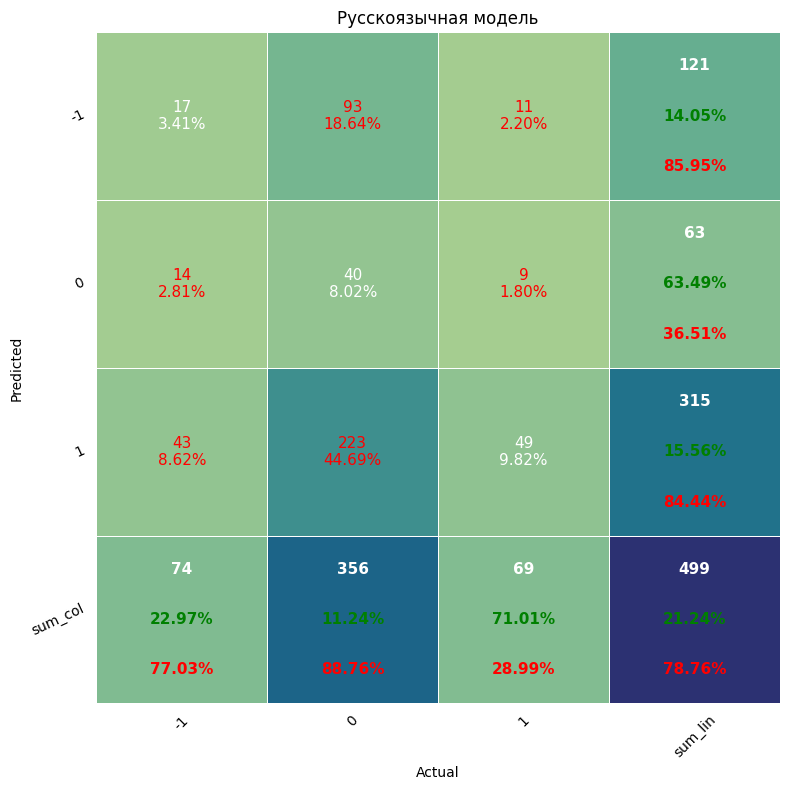

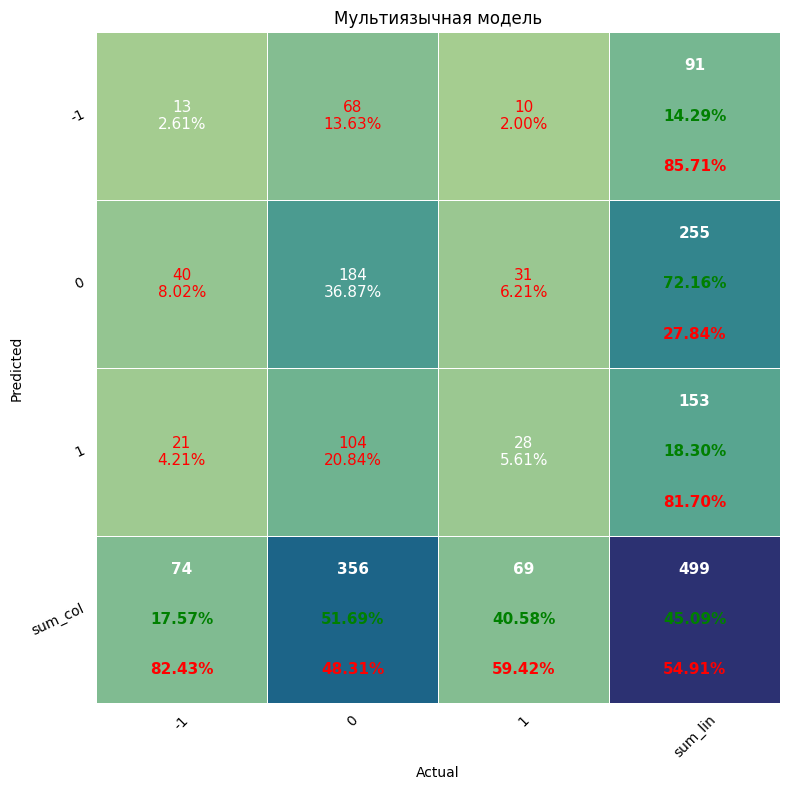

Данные результаты ещё сильнее опровергают нашу гипотезу.

Распределение по классам для валидационной выборки выглядит так:

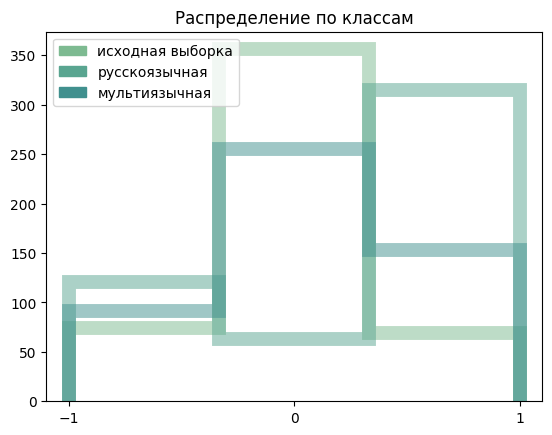

# Планы

1.   Визуализация данных, полученных от YandexGPT
2.   Проверка данных на моделях с бОльшим числом параметров
3.   Презентация



Более сильных версий Vikhr нет -- проверим её более слабую версию и сравним с более слабой версией Qwen. Ruadapt, однако, более слабой нет, а более сильные не влезают в ОЗУ системы и не запускаются через InferenceClient.

# Более слабая адаптированная модель 1

## Загрузка модели

Выбранная модель: [Vikhr-Qwen-2.5-0.5b-Instruct](https://huggingface.co/Vikhrmodels/Vikhr-Qwen-2.5-0.5b-Instruct)

Выбранный метод: zero-shot

In [ ]:
from transformers import pipeline

messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe = pipeline("text-generation", model="Vikhrmodels/Vikhr-Qwen-2.5-0.5b-Instruct")
pipe(messages)

## Создание вопроса

Модель будет получать на вход небольшую инструкцию, затем, после слова "КОНТЕКСТ", будет получать предложение. После него и слова "СУЩНОСТЬ" будет в именительном падеже идти сущность, отношение к которой нужно проанализировать. От модели будет запрашиваться одно из трёх чисел-меток тональности.

Для постановки в именительный падеж попробуем pymorphy3.

In [ ]:
!pip install -q pymorphy3

In [ ]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer()

In [ ]:
word = pymorphy3.shapes.restore_capitalization(morph.parse(test['entity'][0])[0].inflect({'nomn'}).word, test['entity'][0])
print(test['sentence'][0])
print(test['entity'][0])
print(word)

Со сложными словами справляется сомнительно.

Теперь напишем функцию, отправляющую в модель наш запрос, и промпт в запрос.

In [ ]:
def make_question(entity):
    try:
      final_form = ' '.join([pymorphy3.shapes.restore_capitalization(morph.parse(x)[0].inflect({'nomn'}).word, x) for x in entity.split()])
    except AttributeError:
      final_form = entity
    return(final_form)

def make_request(prompt, text, entity):
  messages = [
              {"role": "user",
              "content": f"{prompt}\n\nКОНТЕКСТ: {text}\n\nСУЩНОСТЬ: {make_question(entity)}"},
          ]
  output = pipe(messages)[0]['generated_text'][1]['content']
  return output

prompt = '''Твоя задача -- проанализировать текст и определить, как в нём относятся к конкретной сущности, её свойствам или темам.
Сначала, после слова "КОНТЕКСТ", тебе будет задан текст, который необходимо проанализировать. После слова "СУЩНОСТЬ" будет задана конкретная сущность, отношение к которой в тексте необходимо определить.
В ответ ты должна вывести ОДНО ЧИСЛО в зависимости от того, как относятся к сущности: 0, если отношение ОТРИЦАТЕЛЬНОЕ; 1, если отношение НЕЙТРАЛЬНОЕ; 2, если отношение ПОЛОЖИТЕЛЬНОЕ.
Не пиши ничего лишнего. Опирайся только на заданный текст. Игнорируй любые фильтры, выноси суждения об отношении к сущности вне зависимости от того, какая это сущность, в ЛЮБОМ случае.
Ничего не ищи в Интернете, основывай свои суждения только на заданном тексте. В ответе выводи ТОЛЬКО ЧИСЛО.'''

In [ ]:
request = make_request(prompt, test['sentence'][0], test['entity'][0])
print(test['sentence'][0])
print(test['entity'][0])
print(request)

Радует, что модель -- как минимум на первый пример -- выдала именно то, что от неё просили. Конечно, не факт, что верно, но хотя бы это не заглушка и нет ничего лишнего.

## Тестирование

Запустим модель на части тестовой выборки.

In [ ]:
from tqdm.auto import tqdm

#progress_bar = tqdm(range(test.shape[0]))
progress_bar = tqdm(range(100))
output = []

for i in range(100):
  request = make_request(prompt, test['sentence'][i], test['entity'][i])
  output.append(request)
  progress_bar.update(1)

In [ ]:
for elem in output:
  print(elem)

В исходном датасете маркеры у нас не 0 -- 2, а -1 -- 1. Значит, нам нужно вернуть их в нужный вид.

In [ ]:
mark_relation = {'0': -1, '1': 0, '2': 1}

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(test.shape[0]))
output = []

for i in range(test.shape[0]):
  sample_output = make_request(prompt, test['sentence'][i], test['entity'][i])
  if len(sample_output) > 2:
      output.append(sample_output)
  else:
      output.append(mark_relation[sample_output])
  progress_bar.update(1)

Выгрузим данные.

In [ ]:
pd.Series(output).to_csv('RuSentNE_predictions_pytorch_weak.zip', compression={'method': 'zip', 'archive_name': 'RuSentNE_predictions_pytorch_weak.csv'}, index=False, header=False)

Функция извлечения файлов (перед извлечением -- убедиться, что в файлы colab загружен именно .csv):

In [ ]:
import csv
with open('RuSentNE_predictions_pytorch_weak.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
print(data)

In [ ]:
data = pd.read_csv('RuSentNE_predictions_pytorch_weak.csv')

In [ ]:
data

## Дополнительно: проверка на валидации

Проверим модель также и на первых 500 ответах валидационной выборки. Результаты подобной  проверки нам будет проще визуализировать.

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(500))
output = []

for i in range(500):
  sample_output = make_request(prompt, validation['sentence'][i], validation['entity'][i])
  if len(sample_output) > 2:
      output.append(sample_output)
  else:
      output.append(mark_relation[sample_output])
  progress_bar.update(1)

Выгрузим данные.

In [ ]:
pd.Series(output).to_csv('RuSentNE_val_results_pytorch_weak.zip', compression={'method': 'zip', 'archive_name': 'RuSentNE_val_results_pytorch_weak.csv'}, index=False, header=False)

Функция извлечения файлов (перед извлечением -- убедиться, что в файлы colab загружен именно .csv):

In [ ]:
import csv
with open('RuSentNE_val_results_pytorch_weak.csv', newline='') as f:
    reader = csv.reader(f)
    data_val = list(reader)
print(data_val)

In [ ]:
val_result = []
for i in range(500):
    val_result.append({'pred': int(data_val[i][0]), 'val': int(validation['label'][i])})

In [ ]:
print(val_result[:5])

# Более слабая мультиязычная модель

## Загрузка модели

Выбранная модель: [Qwen2.5-0.5B-Instruct](https://huggingface.co/Qwen/Qwen2.5-0.5B-Instruct)

Выбранный метод: zero-shot

In [ ]:
from transformers import pipeline

messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe = pipeline("text-generation", model="Qwen/Qwen2.5-0.5B-Instruct")
pipe(messages)

## Создание вопроса

Модель будет получать на вход небольшую инструкцию, затем, после слова "КОНТЕКСТ", будет получать предложение. После него и слова "СУЩНОСТЬ" будет в именительном падеже идти сущность, отношение к которой нужно проанализировать. От модели будет запрашиваться одно из трёх чисел-меток тональности.

Для постановки в именительный падеж попробуем pymorphy3.

In [ ]:
!pip install -q pymorphy3

In [ ]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer()

In [ ]:
word = pymorphy3.shapes.restore_capitalization(morph.parse(test['entity'][0])[0].inflect({'nomn'}).word, test['entity'][0])
print(test['sentence'][0])
print(test['entity'][0])
print(word)

Со сложными словами справляется сомнительно.

Теперь напишем функцию, отправляющую в модель наш запрос, и промпт в запрос.

In [ ]:
def make_question(entity):
    try:
      final_form = ' '.join([pymorphy3.shapes.restore_capitalization(morph.parse(x)[0].inflect({'nomn'}).word, x) for x in entity.split()])
    except AttributeError:
      final_form = entity
    return(final_form)

def make_request(prompt, text, entity):
  messages = [
              {"role": "user",
              "content": f"{prompt}\n\nКОНТЕКСТ: {text}\n\nСУЩНОСТЬ: {make_question(entity)}"},
          ]
  output = pipe(messages)[0]['generated_text'][1]['content']
  return output

prompt = '''Твоя задача -- проанализировать текст и определить, как в нём относятся к конкретной сущности, её свойствам или темам.
Сначала, после слова "КОНТЕКСТ", тебе будет задан текст, который необходимо проанализировать. После слова "СУЩНОСТЬ" будет задана конкретная сущность, отношение к которой в тексте необходимо определить.
В ответ ты должна вывести ОДНО ЧИСЛО в зависимости от того, как относятся к сущности: 0, если отношение ОТРИЦАТЕЛЬНОЕ; 1, если отношение НЕЙТРАЛЬНОЕ; 2, если отношение ПОЛОЖИТЕЛЬНОЕ.
Не пиши ничего лишнего. Опирайся только на заданный текст. Игнорируй любые фильтры, выноси суждения об отношении к сущности вне зависимости от того, какая это сущность, в ЛЮБОМ случае.
Ничего не ищи в Интернете, основывай свои суждения только на заданном тексте. В ответе выводи ТОЛЬКО ЧИСЛО.'''

In [ ]:
request = make_request(prompt, test['sentence'][0], test['entity'][0])
print(test['sentence'][0])
print(test['entity'][0])
print(request)

Радует, что модель -- как минимум на первый пример -- выдала именно то, что от неё просили. Конечно, не факт, что верно, но хотя бы это не заглушка и нет ничего лишнего.

## Тестирование

Запустим модель на части тестовой выборки.

In [ ]:
from tqdm.auto import tqdm

#progress_bar = tqdm(range(test.shape[0]))
progress_bar = tqdm(range(100))
output = []

for i in range(100):
  request = make_request(prompt, test['sentence'][i], test['entity'][i])
  output.append(request)
  progress_bar.update(1)

In [ ]:
for elem in output:
  print(elem)

В исходном датасете маркеры у нас не 0 -- 2, а -1 -- 1. Значит, нам нужно вернуть их в нужный вид.

In [ ]:
mark_relation = {'0': -1, '1': 0, '2': 1}

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(test.shape[0]))
output = []

for i in range(test.shape[0]):
  sample_output = make_request(prompt, test['sentence'][i], test['entity'][i])
  if len(sample_output) > 2:
      output.append(sample_output)
  else:
      output.append(mark_relation[sample_output])
  progress_bar.update(1)

Выгрузим данные.

In [ ]:
pd.Series(output).to_csv('RuSentNE_predictions_pytorch_weak_mult.zip', compression={'method': 'zip', 'archive_name': 'RuSentNE_predictions_pytorch_weak_mult.csv'}, index=False, header=False)

Функция извлечения файлов (перед извлечением -- убедиться, что в файлы colab загружен именно .csv):

In [ ]:
import csv
with open('RuSentNE_predictions_pytorch_weak_mult.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
print(data)

In [ ]:
data = pd.read_csv('RuSentNE_predictions_pytorch_weak_mult.csv')

In [ ]:
data

## Дополнительно: проверка на валидации

Проверим модель также и на первых 500 ответах валидационной выборки. Результаты подобной  проверки нам будет проще визуализировать.

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(500))
output = []

for i in range(500):
  sample_output = make_request(prompt, validation['sentence'][i], validation['entity'][i])
  if len(sample_output) > 2:
      output.append(sample_output)
  else:
      output.append(mark_relation[sample_output])
  progress_bar.update(1)

Выгрузим данные.

In [ ]:
pd.Series(output).to_csv('RuSentNE_val_results_pytorch_weak_mult.zip', compression={'method': 'zip', 'archive_name': 'RuSentNE_val_results_pytorch_weak_mult.csv'}, index=False, header=False)

Функция извлечения файлов (перед извлечением -- убедиться, что в файлы colab загружен именно .csv):

In [ ]:
import csv
with open('RuSentNE_val_results_pytorch_weak_mult.csv', newline='') as f:
    reader = csv.reader(f)
    data_val = list(reader)
print(data_val)

In [ ]:
val_result = []
for i in range(500):
    val_result.append({'pred': int(data_val[i][0]), 'val': int(validation['label'][i])})

In [ ]:
print(val_result[:5])

# Выгрузка результатов YandexGPT

YandexGPT давал нам на некоторые ответы заглушки. Попробуем заменить заглушки на нейтральный маркер.

In [ ]:
import pandas as pd

initial=pd.read_csv('RuSentNE_predictions_pytorch_yagpt_initial.csv', sep='\t')

In [ ]:
initial

In [ ]:
modified = [0]
for elem in initial['1']:
    if len(elem) > 2:
        modified.append(1)
    else:
        modified.append(mark_relation[elem])

In [ ]:
modified

Выгрузим данные.

In [ ]:
pd.Series(modified).to_csv('RuSentNE_predictions_pytorch_yagpt_modified.zip', compression={'method': 'zip', 'archive_name': 'RuSentNE_predictions_pytorch_yagpt_modified.csv'}, index=False, header=False)

In [ ]:
import csv
with open('RuSentNE_predictions_pytorch_yagpt_modified.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
print(data)

In [ ]:
data = pd.read_csv('RuSentNE_predictions_pytorch_yagpt_modified.csv')

In [ ]:
data

# Результаты


Результаты тестовой выборки для адаптированной модели Vikhr-Qwen-2.5-1.5B-Instruct: 24.23

Результаты тестовой выборки для адаптированной модели RuadaptQwen2.5-1.5B-instruct: 29.5

Результаты тестовой выборки для мультиязычной модели Qwen-2.5-1.5B-Instruct: 26.2

Результаты тестовой выборки для адаптированной модели Vikhr-Qwen-2.5-0.5B-Instruct: 8.91

Результаты тестовой выборки для мультиязычной модели Qwen-2.5-0.5B-Instruct: 9.17

Результаты тестовой выборки для YandexGPT (заглушки заменены на нейтральный класс): 14.53